<a href="https://colab.research.google.com/github/haoming150ty/Personal-Portfolio/blob/main/Assignment_03_Haoming_Zhang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment 03: Cats vs. Dogs Image Classification Using CNN (100 pts)**
- Instructor: [Jaeung Sim](https://jaeungs.github.io/) (University of Connecticut)
- Course: OPIM 5512 Data Science Using Python
- Release Date: April 3 (Thu), 2025
- Submission Due: April 18 (Fri), 2025

**Objectives**
1. Import and process image datasets for classification models.
1. Build your own CNN-based image classifier.
1. Leverage publicly available codes for the given dataset on Kaggle.

**Introduction**
* Cats vs. Dogs: Which one is cuter? Deep learning can't give you clear answer on this grand question but can help you classify them in a scalable way.
* In this assignment, you'll handle unstructured data without a structural guidance. You will build your own CNN-based model classifying images as either cats or dogs. In doing so, you might refer to or even adopt publicly available codes.
* At this time, **you can't get help from your friends.** You're on your own. You may still use online documents and artificial intelligence (e.g., ChatGPT). **Importantly, the instructor will receive clarification only.** I will not review and comment on your Python codes.

**References (Kaggle)**
* **Original Dataset:**
  * [Cats-vs-Dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/data)
* **Code Examples**
  - [Cats vs Dogs : Image Classification using CNN(95%)](https://www.kaggle.com/code/sachinpatil1280/cats-vs-dogs-image-classification-using-cnn-95)
  - [Cats vs Dogs Classification](https://www.kaggle.com/code/fareselmenshawii/cats-vs-dogs-classification/notebook)
  - [Classifier dogs or cat](https://www.kaggle.com/code/mercury35/classifier-dogs-or-cat)


#### **Part I: Setup** (20 pts)

(10 pts) Import the data and visualize example images for each of cats and dogs.

In [ ]:
# Write codes and show results
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Run this in Colab to upload your Kaggle API key first
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haoming015ty","key":"dc6fe38a8243cf80ecf724aa3bd800a8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
!unzip microsoft-catsvsdogs-dataset.zip -d cats_and_dogs

Streaming output truncated to the last 5000 lines.
  inflating: cats_and_dogs/PetImages/Dog/550.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5500.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5501.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5502.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5503.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5504.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5505.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5506.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5507.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5508.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5509.jpg  
  inflating: cats_and_dogs/PetImages/Dog/551.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5510.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5511.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5512.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5513.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5514.jpg  
  inflating: cats_and_dogs/PetImages/Dog/5515.jpg  
  inflating: ca

In [ ]:
import os
from PIL import Image

base_dir = "cats_and_dogs/PetImages"

for category in ["Cat", "Dog"]:
    folder = os.path.join(base_dir, category)
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            img = Image.open(fpath)
            img.verify()  # Check image integrity
        except:
            os.remove(fpath)


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


(10 pts) Split the data into train (80%) and test (20%) sets

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


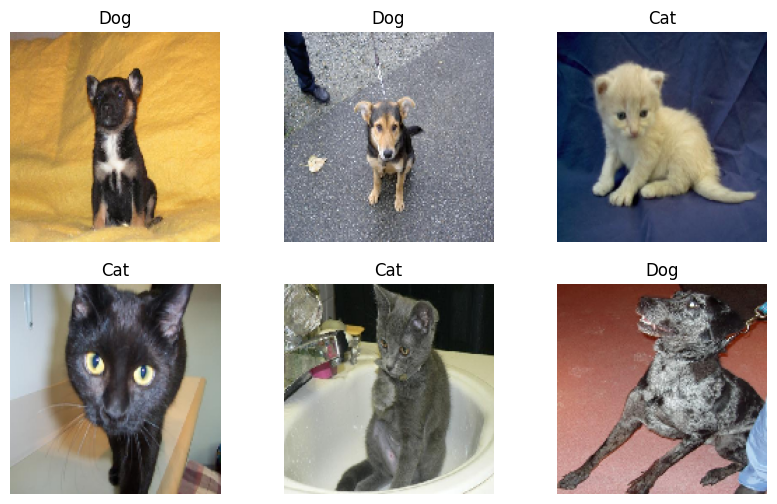

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

import matplotlib.pyplot as plt

class_names = list(train_generator.class_indices.keys())

def show_sample_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        label = class_names[labels[i].argmax()]
        plt.title(label)
        plt.axis('off')
    plt.show()

show_sample_images(train_generator)


#### **Part II: Initial Model** (40 pts)

(20 pts) Train a CNN-based model following this structure:
1. The input layer takes images as input.
1. The first layer applies 32 convolution filters of size 3 x 3 with ReLU activation.
1. A max pooling layer is used to downsample the image, reducing its dimensions.
1. A dropout layer randomly turns off 20% of the neurons to reduce overfitting and improve convergence.
1. The output from the convolutional layers is flattened into a 1D array.
1. A fully connected layer with 256 neurons and ReLU activation is used to obtain all relevant data.
1. Another dropout layer is applied to further reduce overfitting.
1. The output layer consists of 2 neurons, each representing a class, with a softmax activation function to squash the matrix into output probabilities.


In [ ]:
# Write codes and show results
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the CNN model
model = Sequential([
    # Input layer + 1st Conv Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Dropout after pooling

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Additional dropout

    # Output layer
    Dense(2, activation='softmax')  # 2 classes: cat and dog
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model on the training set and validate on the validation set
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # You can increase epochs if needed
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    44,859,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,861,058 (171.13 MB)

 Trainable params: 44,861,058 (171.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 907s 1s/step - accuracy: 0.6222 - loss: 1.6229 - val_accuracy: 0.7325 - val_loss: 0.5434
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 950s 2s/step - accuracy: 0.7570 - loss: 0.5028 - val_accuracy: 0.7415 - val_loss: 0.5313
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.8265 - loss: 0.3913 - val_accuracy: 0.7549 - val_loss: 0.5256
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.8853 - loss: 0.2771 - val_accuracy: 0.7349 - val_loss: 0.6982
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 916s 1s/step - accuracy: 0.9226 - loss: 0.2049 - val_accuracy: 0.7423 - val_loss: 0.6694
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 970s 2s/step - accuracy: 0.9553 - loss: 0.1334 - val_accuracy: 0.7207 - val_loss: 0.8742
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.9649 - loss: 0.1081 - val_accuracy: 0.7371 - val_loss: 0.8420
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 915s 1s/step - accuracy: 0.9714 - loss: 0.0904 - val_accuracy: 0.736

(20 pts) For each of the train and the test sets, present its confusion matrix and classification report, which contains precision, recall, and F1-score for each of cats and dogs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


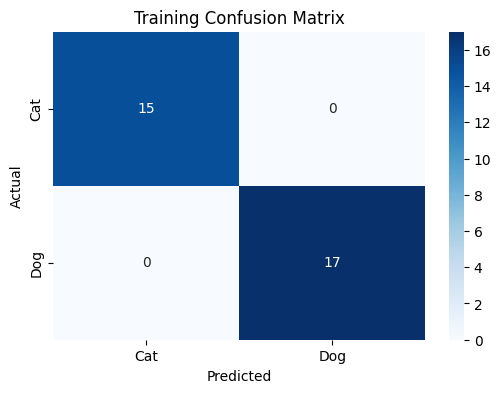

Training Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00        15
         Dog       1.00      1.00      1.00        17

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
# Write codes and show results (Train set)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get a batch of training data
train_images, train_labels = next(train_generator)
# Predict probabilities
train_predictions = model.predict(train_images)
# Convert probabilities to class labels
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(train_labels, axis=1)

# Confusion Matrix
train_cm = confusion_matrix(train_true_classes, train_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(train_cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Training Classification Report:")
print(classification_report(train_true_classes, train_pred_classes, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


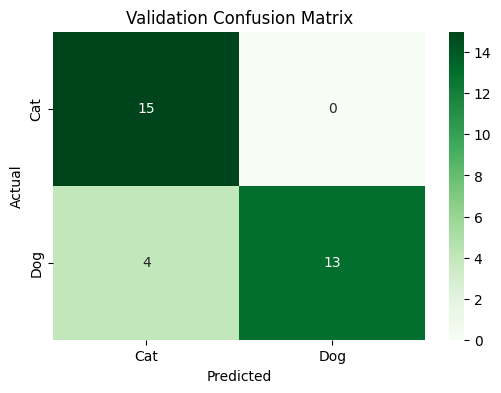

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.79      1.00      0.88        15
         Dog       1.00      0.76      0.87        17

    accuracy                           0.88        32
   macro avg       0.89      0.88      0.87        32
weighted avg       0.90      0.88      0.87        32



In [ ]:
# Write codes and show results (Test set)
# Get a batch of validation data
val_images, val_labels = next(val_generator)
# Predict probabilities
val_predictions = model.predict(val_images)
# Convert probabilities to class labels
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)

# Confusion Matrix
val_cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(val_cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Validation Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_names))

#### **Part III: Better Model** (40 pts)

Either develop or bring a model that **performs better** than the previous model in both the train and the test sets.

(20 pts) Train a model and describe its structure specifically.

### Applying Transfer Learning using MobileNetV2 with Early Stopping

In [ ]:
# Write codes and show results
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model (pretrained on ImageNet)
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers for feature extraction

# Build the Transfer Learning Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # 2 classes: Cat and Dog

transfer_model = Model(inputs=base_model.input, outputs=output)

transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # you can also use 'val_accuracy'
    patience=3,               # stop after 3 epochs with no improvement
    restore_best_weights=True  # roll back to the best weights
)

# Fit the model with EarlyStopping callback
history_transfer = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)


<ipython-input-10-4c473bdf2d5b>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 475s 752ms/step - accuracy: 0.8905 - loss: 0.2750 - val_accuracy: 0.9614 - val_loss: 0.0946
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 478s 766ms/step - accuracy: 0.9580 - loss: 0.1045 - val_accuracy: 0.9642 - val_loss: 0.0875
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 471s 754ms/step - accuracy: 0.9666 - loss: 0.0871 - val_accuracy: 0.9646 - val_loss: 0.0842
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 513s 820ms/step - accuracy: 0.9688 - loss: 0.0789 - val_accuracy: 0.9674 - val_loss: 0.0807
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 463s 741ms/step - accuracy: 0.9716 - loss: 0.0681 - val_accuracy: 0.9654 - val_loss: 0.0872
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 465s 743ms/step - accuracy: 0.9739 - loss: 0.0654 - val_accuracy: 0.9662 - val_loss: 0.0795
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 459s 735ms/step - accuracy: 0.9778 - loss: 0.0585 - val_accuracy: 0.9666 - val_loss: 0.0778
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 459s 735ms/step - accuracy: 0.9799 -

(20 pts) For each of the train and the test sets, present its confusion matrix and classification report, which contains precision, recall, and F1-score for each of cats and dogs.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(generator, model, title):
    images, labels = next(generator)
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"{title} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


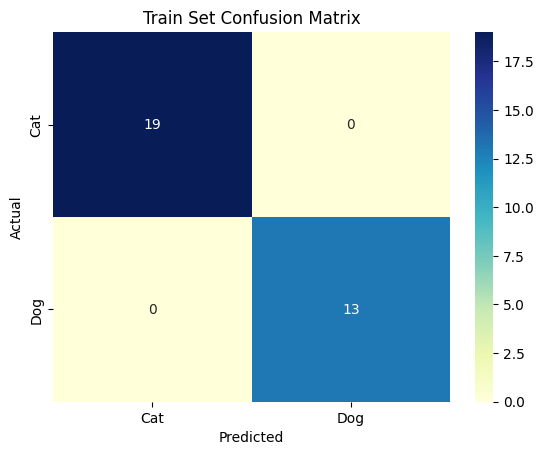

Train Set Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00        19
         Dog       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
# Write codes and show results (Train set)
evaluate_model(train_generator, transfer_model, "Train Set")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


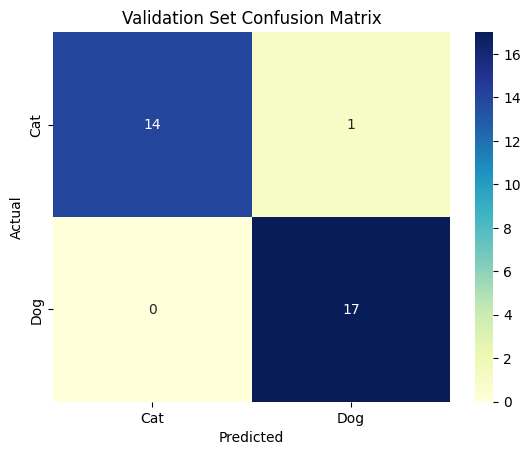

Validation Set Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      0.93      0.97        15
         Dog       0.94      1.00      0.97        17

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



In [ ]:
# Write codes and show results (Test set)
evaluate_model(val_generator, transfer_model, "Validation Set")

End of Document